# Autoria

* Cristiano Sampaio Pinheiro, RA 256352
* Jhonatan Cléto, RA 256444
* Mylena Roberta dos Santos, RA 222687

# Bibliotecas e Paths

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/MC936/P4/'
PATH_DATA = PATH + 'data/'
PATH_TRAIN = PATH_DATA + 'Train/'
PATH_LES = PATH_DATA + 'LES/'
PATH_ASSETS = PATH + 'assets/'

Mounted at /content/drive


# Funções

In [54]:
def open_df(fname:str, path:str=PATH_DATA) -> pd.DataFrame:

  df = pd.read_csv(path+fname)
  df.dropna(inplace=True)
  df.reset_index(inplace=True)

  if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

  return df

def open_img(img:str, path:str=PATH_LES) -> np.array:

  try:
    img_f = Image.open(path+img)
    img_m = np.array(img_f)
    return img_m

  except:
    print("Ocorreu um erro ao abrir a imagem")
    return np.zeros(2, 2)

def open_roi(img:str, mask:str, path:str=PATH_LES) -> np.array:

  img_m = open_img(img, path=path)
  mask_m = open_img(mask, path=path)

  if (mask_m.min() == 253):
    mask_m = mask_m-253

  # Obtem índices de elementos diferentes de 0
  white_pt_coords=np.argwhere(mask_m)

  # Obtem limites
  min_y = min(white_pt_coords[:,0])
  min_x = min(white_pt_coords[:,1])
  max_y = max(white_pt_coords[:,0])
  max_x = max(white_pt_coords[:,1])

  return (img_m*mask_m)[min_y:max_y,min_x:max_x]

def show_img(img:np.array, cmap:str='gray'):
  plt.figure(figsize=(6, 6))
  plt.imshow(img, cmap=cmap)
  plt.show()

def plot_img_set(img_set:list, info:str, name:str):
  
  fig, axs = plt.subplots(1,3, figsize=(20, 6))
  fig.suptitle(info, fontsize=16)

  for i in range(len(img_set)):
    axs[i].imshow(img_set[i], cmap='gray')
  plt.savefig(f"{PATH_ASSETS}patient_634_cuts_{name}.png")
  plt.show()

def img_dict(imgs:list, masks:list, areas:list) -> dict:
  """
    ## Descrição:
     - Constrói um dicionário com as imagens, máscaras e
     tamanho das máscaras de cada paciente no conjunto

    ## Entrada:
     - imgs: Lista com os paths de todas as imagens
     do conjunto
     - masks: Lista com os paths das máscaras do
     conjunto
     - areas: Lista com o tamanho das máscaras do
     conjunto
    
    ## Saída:
     - img_dict: dicionário em que as chaves são os ids
     dos pacientes e os valores são dicionários contendo
     listas das imagens, máscaras e áreas das máscaras
     dos cortes selecionadas para cada paciente
  """

  img_dict = dict()

  for i in range(len(imgs)):
    imp = imgs[i]
    pnum = imp[:3] # obtem o id do paciente

    if pnum in img_dict.keys():
      img_dict[pnum]['imgs'].append(imp)  
      img_dict[pnum]['masks'].append(masks[i])
      img_dict[pnum]['areas'].append(areas[i])

    else:
      dt = {
            'imgs': [imp],
            'masks': [masks[i]],
            'areas': [areas[i]]
           }
      
      img_dict[pnum] = dt

  return img_dict

# Abrir arquivos com os resultados

In [4]:
# Features
avc_features_df = open_df('avc_features.csv')
em_features_df = open_df('em_features.csv')
les_features_df = open_df('les_features.csv')
les_labels_df = open_df('les_classification.csv')

targets = les_labels_df.drop(columns=['patient'])
les_features_df = les_features_df.join(targets)

# Lista de Imagens
avc_set_df = open_df('avc_set_df.csv')
em_set_df = open_df('em_set_df.csv')
les_set_df = open_df('les_set_df.csv')

les_imgs = les_set_df['imgs']
les_masks = les_set_df['masks']
les_areas = les_set_df['areas']

# Análises

## Quantitativas

In [5]:
# Proporção da quantidade de cada etiologia em relação ao total de imagens
les_features_df['target'].value_counts(normalize=True)

AVC    0.750742
EM     0.249258
Name: target, dtype: float64

In [6]:
# Top-10 Cortes com maoires áreas
les_features_df.sort_values(by='area', ascending=False)[:10]

,patient,min,max,mean,variance,skewness,kurtosis,contrast_sum,correlation_sum,energy_sum,...,rlu,rpc,min_LBP,max_LBP,mean_LBP,variance_LBP,skewness_LBP,kurtosis_LBP,area,target
438,648,237,6841,1930.25,5.442123e+06,1.236976,-0.006859,2453.053806,3.173031,0.070458,...,136013.982,1.661,0,39165,2429.266667,5.383084e+07,4.511242,19.614580,38630,AVC
628,671,65,582,293.45,2.863447e+04,0.048314,-1.178524,5843.084697,3.066620,0.057479,...,21319.081,0.478,0,9859,497.933333,3.296765e+06,4.831662,22.243378,5884,AVC
423,647,0,1000,262.85,1.085994e+05,1.159096,-0.039492,1024.785532,3.442991,0.083307,...,18896.169,0.406,0,29756,1150.633333,2.923393e+07,5.186838,24.948737,5260,AVC
424,647,22,701,234.65,5.428213e+04,0.833169,-0.814062,3721.213036,3.226892,0.078049,...,16832.020,0.333,0,31438,1188.933333,3.267783e+07,5.189913,24.969655,4711,AVC
422,647,2,720,174.80,4.613912e+04,1.333276,0.642296,1002.324993,3.566159,0.088026,...,12707.132,0.288,0,28195,1045.833333,2.630958e+07,5.194204,24.999017,3500,AVC
427,647,1,360,152.40,2.069425e+04,0.327913,-1.620361,10835.597770,2.839423,0.082508,...,10829.507,0.451,0,4507,241.833333,6.823313e+05,4.845562,22.387924,3071,AVC
527,656,41,236,151.65,4.724450e+03,-0.413523,-1.415714,9451.500948,2.605802,0.064516,...,11602.574,0.195,0,41144,1458.000000,5.619756e+07,5.197223,25.019362,3045,AVC
495,652,76,205,140.80,1.946905e+03,0.145666,-1.379605,22732.651426,1.968796,0.065335,...,10754.401,0.214,0,38420,1360.700000,4.901837e+07,5.194927,25.003700,2845,AVC
219,628,5,521,138.20,3.976101e+04,1.091809,-0.578037,3321.723351,2.823194,0.100583,...,9523.995,0.218,0,14626,568.966667,7.080448e+06,5.163579,24.784451,2768,AVC
430,647,1,458,135.40,2.075299e+04,0.942814,-0.370036,9483.009323,2.928710,0.087704,...,9673.005,0.449,0,3208,188.533333,3.472549e+05,4.748261,21.642709,2741,AVC


In [7]:
# Top-10 Cortes com menores áreas
les_features_df.sort_values(by='area', ascending=True)[:10]

,patient,min,max,mean,variance,skewness,kurtosis,contrast_sum,correlation_sum,energy_sum,...,rlu,rpc,min_LBP,max_LBP,mean_LBP,variance_LBP,skewness_LBP,kurtosis_LBP,area,target
544,657,0,1,0.20,0.168421,1.500000,0.250000,12161.000000,-2.024079,2.414214,...,16.000,0.032,0,0,0.000000,0.000000,0.000000,-3.000000,6,AVC
344,641,0,4,0.20,0.800000,4.129483,15.052632,68.000000,-2.021978,2.414214,...,16.000,0.032,0,0,0.000000,0.000000,0.000000,-3.000000,8,AVC
389,644,0,2,0.30,0.326316,1.703354,1.908429,3700.666667,-1.580498,2.322462,...,24.000,0.000,0,354,11.800000,4177.200000,5.199469,25.034483,8,AVC
629,672,0,3,0.25,0.513158,3.139888,9.179487,750.666667,-1.505583,2.115355,...,20.000,0.028,0,1,0.033333,0.033333,5.199469,25.034483,9,AVC
405,645,0,2,0.20,0.273684,2.534424,5.390533,2622.000000,-2.005144,2.414214,...,16.000,0.032,0,0,0.000000,0.000000,0.000000,-3.000000,9,AVC
592,665,0,3,0.30,0.642105,2.569133,5.314163,149227.500000,-1.498332,1.724745,...,24.000,0.032,0,3,0.133333,0.326437,4.539858,19.798453,10,AVC
260,632,0,2,0.25,0.407895,2.254196,3.373569,167477.000000,-2.022881,2.115355,...,20.000,0.028,0,1,0.033333,0.033333,5.199469,25.034483,10,AVC
585,663,0,3,0.35,0.871053,2.442039,4.233569,124783.733333,-0.874122,1.745097,...,25.333,0.027,0,2,0.133333,0.188506,3.317740,10.329566,11,AVC
660,674,0,6,0.40,1.936842,3.577070,11.627599,393.033333,-0.631103,1.424440,...,29.286,0.039,0,1,0.033333,0.033333,5.199469,25.034483,11,AVC
591,664,0,3,0.35,0.660526,2.310021,4.279202,904.083333,-0.485765,1.523603,...,28.000,0.036,0,2,0.066667,0.133333,5.199469,25.034483,11,AVC


In [8]:
# Constrói de um DataFrame que contêm as classificações de cortes por paciente
les_grouped = les_labels_df[['patient', 'target']].value_counts().reset_index()
les_grouped = les_grouped.pivot_table(0, ['patient'], 'target')
les_grouped.reset_index(drop=False, inplace=True)
les_grouped.replace(np.nan, 0, inplace=True)
les_grouped['AVC_p'] = round(les_grouped['AVC']/(les_grouped['AVC']+les_grouped['EM'])* 100, 2)
les_grouped['EM_p'] = round(les_grouped['EM']/(les_grouped['AVC']+les_grouped['EM'])* 100, 2)

In [9]:
# Definição dos grupos de interesse
avc = les_grouped.query("AVC_p >= 70") # AVC predominante
em = les_grouped.query('EM_p >= 70') # EM predominante
half = les_grouped.query('AVC_p < 70 & EM_p < 70') # Equilibrado

In [65]:
avc

target,patient,AVC,EM,AVC_p,EM_p
0,600,9.0,1.0,90.00,10.00
1,601,3.0,1.0,75.00,25.00
2,602,10.0,1.0,90.91,9.09
3,603,9.0,0.0,100.00,0.00
4,604,4.0,0.0,100.00,0.00
6,606,6.0,1.0,85.71,14.29
7,607,7.0,2.0,77.78,22.22
8,608,15.0,2.0,88.24,11.76
9,609,10.0,1.0,90.91,9.09
10,610,9.0,2.0,81.82,18.18


In [66]:
em

target,patient,AVC,EM,AVC_p,EM_p
30,630,0.0,2.0,0.0,100.0
60,660,0.0,2.0,0.0,100.0
74,675,0.0,1.0,0.0,100.0
76,677,0.0,1.0,0.0,100.0


In [67]:
half

target,patient,AVC,EM,AVC_p,EM_p
5,605,2.0,1.0,66.67,33.33
13,613,8.0,4.0,66.67,33.33
18,618,2.0,1.0,66.67,33.33
19,619,3.0,2.0,60.00,40.00
23,623,6.0,5.0,54.55,45.45
29,629,12.0,6.0,66.67,33.33
31,631,5.0,5.0,50.00,50.00
33,633,2.0,1.0,66.67,33.33
34,634,3.0,3.0,50.00,50.00
35,635,11.0,5.0,68.75,31.25


In [10]:
# Obter as features dos paciêntes dos grupos de interesse
avc_significant = avc['patient']
les_avc_group = les_features_df.query("patient in @avc_significant")

em_significant = em['patient']
les_em_group = les_features_df.query("patient in @em_significant")

half_significant = half['patient']
les_half_group = les_features_df.query("patient in @half_significant")

In [11]:
# GRUPO AVC sem Outliers
# les_avc_soutiliers_group = les_avc_group.query("area <= 10000")
# round(les_avc_soutiliers_group.describe(), 2).to_csv(PATH_DATA+'les_avc_soutliers_statistics.csv')

# Grupo HALF mais específico
# half_significant = half.query("AVC_p >= 40 & AVC_p <= 60")['patient']
# les_half_group = les_features_df.query("patient in @half_significant")
# round(les_half_group.describe(), 2).to_csv(PATH_DATA+'half_half_statistics.csv')

#round(les_half_group.describe(),2).to_csv(PATH_DATA+'half_group_statistics.csv')
#round(les_avc_group.describe(),2).to_csv(PATH_DATA+'avc_group_statistics.csv')
#round(les_em_group.describe(),2).to_csv(PATH_DATA+'em_group_statistics.csv')

In [71]:
# Porcentagam dos pacientes em cada grupo em relação ao total
p_avc = round(len(avc.index)/len(les_grouped.index) * 100, 2)
p_em = round(len(em.index)/len(les_grouped.index) * 100, 2)
p_half = round(len(half.index)/len(les_grouped.index) * 100, 2)

pd.DataFrame(data=[[p_avc, p_em, p_half],], index=['%'], columns=['AVC', 'EM', 'INCERTO'])

,AVC,EM,INCERTO
%,62.82,5.13,32.05


## Qualitativa

### Relação entre features

In [ ]:
# Concatenar um DataFrame com todo o grupo de interesse para análises qualitativas
les_half_group['target'] = 'INCERTO'
les_avc_group['target'] = 'AVC'
les_em_group['target'] = 'EM'
everybory = pd.concat((les_half_group, les_avc_group, les_em_group))

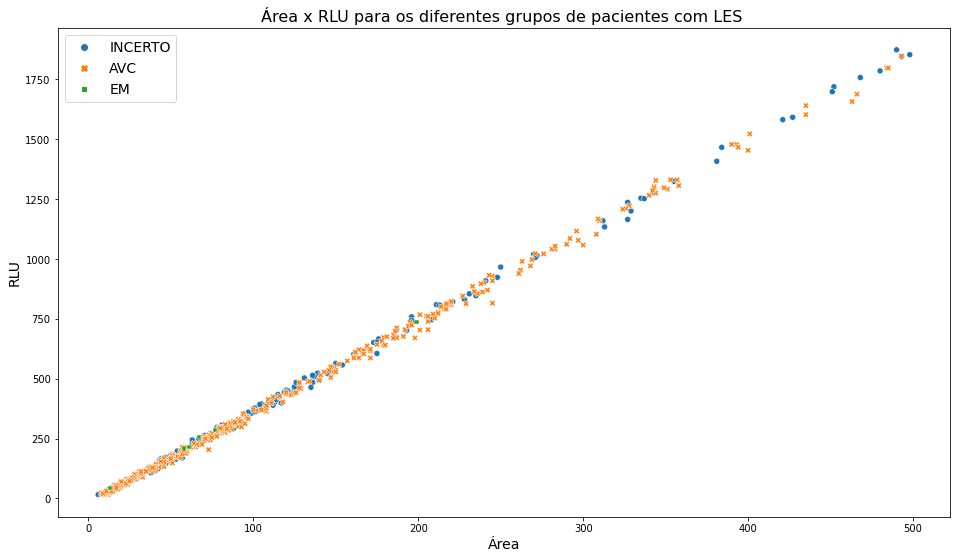

In [64]:
data = everybory.query('area < 500')
plt.figure(figsize=(16, 9))
ax = sns.scatterplot(data=data, x='area', y='rlu', hue='target', style='target')
plt.title("Área x RLU para os diferentes grupos de pacientes com LES ", fontsize=16)
plt.savefig(PATH_ASSETS+'area_vs_rlu.png')
ax.set_xlabel("Área", fontsize=14)
ax.set_ylabel("RLU", fontsize=14)
ax.legend(fontsize=14)
plt.show()

### Imagens do Paciente 634 que apresentou 50%-50% na distribuição dos cortes

In [ ]:
les_dict = img_dict(les_imgs, les_masks, les_areas)
cut = 2
patient = '634'
img = les_dict[patient]['imgs'][cut]
mask = les_dict[patient]['masks'][cut]
show_img(open_img(img))
show_img(open_img(mask))
show_img(open_roi(img, mask))

In [28]:
les_features_df.query('patient == 634')

,patient,min,max,mean,variance,skewness,kurtosis,contrast_sum,correlation_sum,energy_sum,...,rlu,rpc,min_LBP,max_LBP,mean_LBP,variance_LBP,skewness_LBP,kurtosis_LBP,area,target
265,634,1,19,6.85,31.292105,0.871965,-0.396094,27963.138842,1.483365,0.264737,...,521.311,0.132,0,68,5.333333,2.085747e+02,3.621866,11.897910,145,AVC
266,634,0,13,4.05,20.786842,0.756519,-0.656253,4771.813239,1.814983,0.357803,...,318.050,0.096,0,75,4.933333,1.910989e+02,4.567206,20.574426,88,EM
267,634,0,7,1.25,4.513158,1.488964,0.934118,1756.714912,1.327967,0.712582,...,91.818,0.054,0,10,0.966667,4.033333e+00,3.319645,11.898794,29,AVC
268,634,0,3,0.50,1.105263,1.672972,1.047619,1078.000000,0.525493,1.188392,...,40.000,0.040,0,2,0.133333,2.574713e-01,3.474396,10.071429,13,EM
269,634,0,28,10.30,64.010526,0.547540,-0.588472,13953.548277,1.769207,0.230329,...,809.088,0.024,0,9010,306.333333,2.702406e+06,5.199071,25.031811,211,EM
270,634,0,21,8.60,51.936842,0.276338,-1.106196,25735.160234,1.038490,0.256614,...,666.202,0.023,0,8948,303.000000,2.666191e+06,5.198781,25.029855,176,AVC


In [33]:
print(les_dict[patient]['areas'])
print(les_dict[patient]['imgs'])
print(les_dict[patient]['masks'])

[145, 88, 29, 13, 211, 176]
['634_FLAIR11.png', '634_FLAIR12.png', '634_FLAIR13.png', '634_FLAIR19.png', '634_FLAIR20.png', '634_FLAIR21.png']
['634_FLAIR11_mask.png', '634_FLAIR12_mask.png', '634_FLAIR13_mask.png', '634_FLAIR19_mask.png', '634_FLAIR20_mask.png', '634_FLAIR21_mask.png']


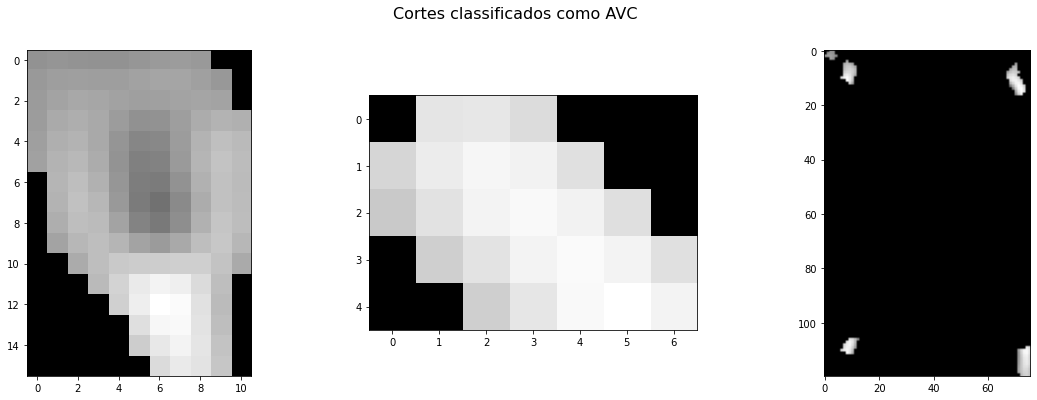

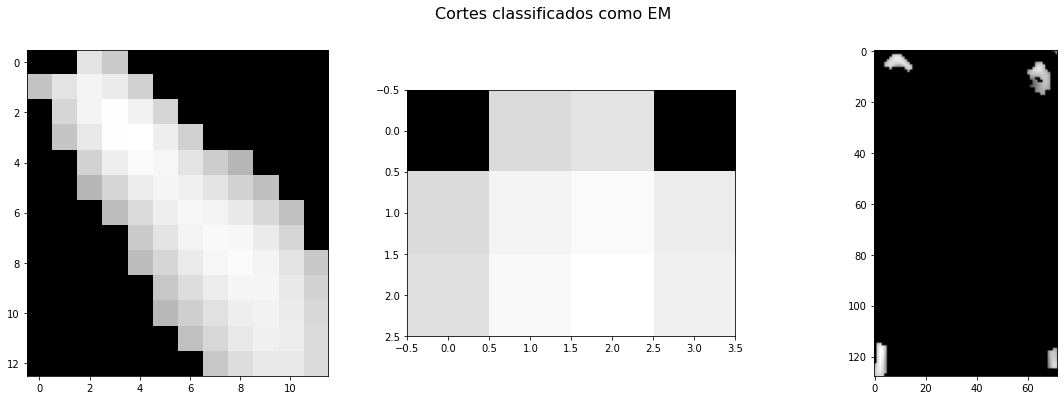

In [55]:
p634_avc_idx = [0, 2, 5]
p634_em_idx = [1, 3, 4]

# Conjunto de imagens classificadas como AVC do paciente 634
p634_avc_set = list(
                  map(
                      lambda i: open_roi(
                                          les_dict[patient]['imgs'][i],
                                          les_dict[patient]['masks'][i]
                                        ),
                      p634_avc_idx
                     )
                )

# Conjunto de imagens classificadas como EM do paciente 634
p634_em_set = list(
                  map(
                      lambda i: open_roi(
                                          les_dict[patient]['imgs'][i],
                                          les_dict[patient]['masks'][i]
                                        ),
                      p634_em_idx
                     )
                )

p634_avc_info = 'Cortes classificados como AVC'
p634_em_info = 'Cortes classificados como EM'

plot_img_set(p634_avc_set, p634_avc_info, 'avc')
print()
plot_img_set(p634_em_set, p634_em_info, 'em')